#### 1. Сохраняем данные в переменную taxi, разделитель — ;.  Приведим столбцы start_at, end_at, arrived_at к формату даты, используя pd.to_datetime(). Фильтруем данные и оставляем наблюдения со статусом заказа "asap" и "reserved" (start_type).

In [1]:
import pandas as pd

Импотрируем данные поездок такси в Перу

In [2]:
taxi = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/project_3_python/3_taxi_peru.csv', 
                 sep = ';')

In [6]:
taxi[['start_at', 'arrived_at','end_at']] = taxi[['start_at', 'arrived_at','end_at']].apply(pd.to_datetime)

In [4]:
taxi = taxi.query("start_type == 'asap' or start_type == 'reserved'")

In [5]:
taxi.head()

,journey_id,user_id,driver_id,taxi_id,icon,start_type,start_at,start_lat,start_lon,end_at,end_lat,end_lon,end_state,driver_start_lat,driver_start_lon,arrived_at,source,driver_score,rider_score
0,23a1406fc6a11d866e3c82f22eed4d4c,0e9af5bbf1edfe591b54ecdfd7e91e26,583949a89a9ee17d19e3ca4f137b6b4c,b12f4f09c783e29fe0d0ea624530db56,executive,asap,2010-11-16 16:44:00,"-12,13983536","-77,02355957",2010-11-16 17:29:00,"-12,05537033","-77,0413208",drop off,"-12,10825481","-77,0272739",2010-11-16 17:02:00,iPhone,5.0,5.0
1,dd2af4715d0dc16eded53afc0e243577,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-06-01 00:34:00,"-12,13874817","-76,99536133",2010-06-01 00:37:00,"-12,12465668","-77,02886963",not found,NaN,NaN,NaT,iPhone,NaN,NaN
2,dd91e131888064bf7df3ce08f3d4b4ad,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-05-31 05:01:00,"-12,12453079","-77,02780151",2010-05-31 05:04:00,"-12,13883209","-76,99530029",not found,NaN,NaN,NaT,iPhone,NaN,NaN
3,dd2af4715d0dc16eded53afc0e2466d0,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-06-01 00:29:00,"-12,13885117","-76,99530029",2010-06-01 00:32:00,"-12,12458801","-77,02896118",not found,NaN,NaN,NaT,iPhone,NaN,NaN
4,85b7eabcf5d84e42dc7629b7d27781af,56772d544fdfa589a020a1ff894a86f7,d665fb9f75ef5d9cd0fd89479380ba78,0accdd3aa5a322f4129fa20b53278c69,executive,reserved,2010-09-11 23:55:00,"-12,08995438","-76,92626953",2010-09-12 01:07:00,"-12,02223206","-77,10638428",drop off,"-12,08311558","-76,9277072",2010-09-11 23:50:00,iPhone,4.0,5.0


 #### 2. Создадим колонку wait_time, в которой будет храниться разница между временем подачи машины (arrived_at) и временем заказа (start_at) в минутах.

In [7]:
taxi['wait_time'] = taxi.arrived_at - taxi.start_at
taxi['wait_time'] = taxi.wait_time.astype('timedelta64[m]')

#### 3.Посмотрим, какие водители опаздывали на заказы к определенному времени (start_type == 'reserved'). Опозданием считается время ожидания wait_time > 0.0. Сгруппируем отфильтрованные данные по driver_id и вычислим id водителя, который опоздал на заказ интересующего нас типа наибольшее число раз

In [9]:
taxi.query("start_type == 'reserved' & wait_time > 0.0").groupby('driver_id', as_index=False)\
    .agg({'wait_time':'count'}).sort_values('wait_time', ascending=False)

,driver_id,wait_time
24,406921adcca37705ef527b4246c0cfea,67
86,d665fb9f75ef5d9cd0fd89479380ba78,59
93,ec84a73745199ff840ecafcb924383ad,57
29,56f59b58bcbbd1cdabc3652e713134c2,51
77,c814db2127582cf95dea1f74f43127c2,45
...,...,...
88,d7bf644eb441cda6127f91addebb85c4,1
71,b68895736389f2949faa8c73555b81ac,1
51,8cb98e46b27af1e6fca8768a2a6329f3,1
16,389bfa333ba8fa7281dd5f0e1b57c0c1,1


In [10]:
taxi.loc[(taxi.start_type == 'reserved') & (taxi.wait_time > 0)].driver_id.value_counts().idxmax()

'406921adcca37705ef527b4246c0cfea'

#### 4. Что может влиять на число опозданий из прошлого задания. 

##### Гипотеза 1: у него самые долгие поездки, и не получается рассчитывать время (например, стоял в пробке)

* Проверим: посчитаем медиану продолжительности поездок по водителям, и посмотрим, войдет ли искомый водитель в топ:

In [19]:
taxi['duration'] = taxi.end_at - taxi.start_at
taxi['duration'] = taxi.duration.astype('timedelta64[m]')

In [20]:
taxi.query("start_type == 'reserved'").groupby('driver_id', as_index=False)\
    .agg({'duration':'median'}).sort_values('duration', ascending=False)

,driver_id,duration
86,a7b047c6a09ccb85e9980d80ffaadb3d,145.0
72,86981d5cc39076d9d0281221fe19f3fa,86.0
2,0fd4a08189ac948f6beaa2d3145c81b6,85.0
22,2d163dcf6f3e01abf4af5b2a721ec5ac,84.0
134,f8cd07f929f6884cd5fea893f4da3461,83.0
...,...,...
47,587ea1ea1ab415acb010ec8308275095,6.0
0,031fea9628f9238b051a58808554498a,5.0
20,2ca81f8112b8c60af222ee2ed7278078,4.0
5,1238e44402a93366489cbff9884bc267,-4.0


Здесь искомого айди нет (406921adcca37705ef527b4246c0cfea). Наш водитель не в топ-10, так что гипотезу отбрасываем.

##### Гипотеза 2: у него в принципе больше всех поездок, поэтому он и опаздывает больше всех 
* Проверим: найдем топ-5 по числу поездок:

In [45]:
taxi_journeys = taxi.query("start_type == 'reserved'").groupby('driver_id', as_index=False)\
    .agg({'taxi_id':'count'})\
    .rename(columns={"taxi_id": "n_journeys"}).sort_values('n_journeys', ascending=False)
taxi_journeys.head()

,driver_id,n_journeys
119,d665fb9f75ef5d9cd0fd89479380ba78,579
109,c814db2127582cf95dea1f74f43127c2,385
34,406921adcca37705ef527b4246c0cfea,363
143,ff5c924e0b630fd7c019a4234059fdf4,359
33,406921adcca37705ef527b4246bbbff5,346


Наш водитель на 3м месте, но не на 1м. Сравним с топом "опаздывающих":

In [46]:
taxi_lates = taxi.query("start_type == 'reserved' & wait_time > 0.0").groupby('driver_id', as_index=False)\
    .agg({'wait_time':'count'})\
    .rename(columns={"wait_time": "n_lates"}).sort_values('n_lates', ascending=False)
taxi_lates.head()

,driver_id,n_lates
24,406921adcca37705ef527b4246c0cfea,67
86,d665fb9f75ef5d9cd0fd89479380ba78,59
93,ec84a73745199ff840ecafcb924383ad,57
29,56f59b58bcbbd1cdabc3652e713134c2,51
77,c814db2127582cf95dea1f74f43127c2,45


Видим, что трое водителей присутствуют в обоих топах. Логично – кто больше ездит, тот больше и опаздывает. Попробуем посмотреть не на абсолютное число опозданий, а на их долю – и там, возможно, наш водитель будет не самым опаздывающим.

In [54]:
reserved_journeys = taxi_journeys.merge(taxi_lates, on='driver_id')

In [55]:
reserved_journeys['late_score'] = (reserved_journeys.n_lates /reserved_journeys.n_journeys).round(2)

In [56]:
reserved_journeys.sort_values('n_lates', ascending=False).head(5)

,driver_id,n_journeys,n_lates,late_score
2,406921adcca37705ef527b4246c0cfea,363,67,0.18
0,d665fb9f75ef5d9cd0fd89479380ba78,579,59,0.10
5,ec84a73745199ff840ecafcb924383ad,330,57,0.17
14,56f59b58bcbbd1cdabc3652e713134c2,130,51,0.39
1,c814db2127582cf95dea1f74f43127c2,385,45,0.12


Здесь наш водитель на первом месте по доле опозданий – опоздания случились в 67 поездках из 363, или в 18% случаев.

In [57]:
reserved_journeys.late_score.describe()

count    105.000000
mean       0.219905
std        0.167398
min        0.020000
25%        0.120000
50%        0.170000
75%        0.260000
max        1.000000
Name: late_score, dtype: float64

Но в целом среди всех водителей он не так плох: около половины водителей опаздывали чаще (медианная доля опозданий 17,4%)

Вывод – наш водитель:

* один из самых активных (совершает много поездок)
* не очень пунктуальный (хоть и не самый)

Сойдясь в одной точке, эти факторы вывели его в топ опаздывающих. Будь он чуть пунктуальней, или езди чуть реже – этого бы не случилось.

Третим возможным фактором является то, что в топе самых активных водителей рядом с нашим героем оказались самые ответственные люди - их доля опозданий меньше, чем у 75% водителей и с ними просто трудно конкурировать.

#### 5.Добавим столбец month, где будет храниться номер месяца, в котором был сделан заказ (start_at), и столбец weekday – название дня недели.

In [58]:
taxi['month'] = taxi.start_at.dt.month
taxi['weekday'] = taxi.start_at.dt.day_name()
taxi[['start_at', 'month', 'weekday']].head()

,start_at,month,weekday
0,2010-11-16 16:44:00,11,Tuesday
1,2010-06-01 00:34:00,6,Tuesday
2,2010-05-31 05:01:00,5,Monday
3,2010-06-01 00:29:00,6,Tuesday
4,2010-09-11 23:55:00,9,Saturday


#### 6. Построим график числа заказов по месяцам (month). В какой месяц суммарно поступает меньше всего заказов?

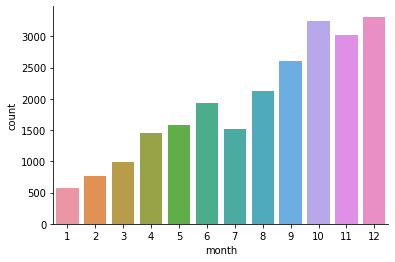

In [59]:
import seaborn as sns
sns.countplot(data=taxi, x='month')
sns.despine()

#### 7. А теперь – график по дням недели (weekday). В какой день недели суммарно поступает меньше всего заказов?

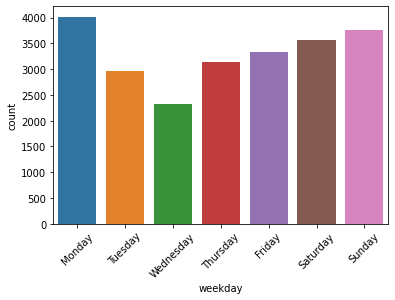

In [60]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.countplot(data=taxi, x='weekday', order=order)
ax.tick_params(axis='x', rotation=45)

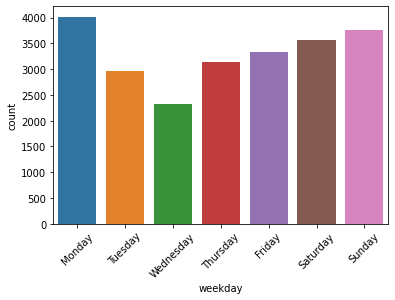

In [62]:
# второй вариант
taxi.weekday = pd.Categorical(taxi.weekday, ordered=True, categories=order)
ax = sns.countplot(data=taxi, x='weekday')
ax.tick_params(axis='x', rotation=45)

#### 8. Посмотрим на метрики DAU, MAU, WAU, показывающих число уникальных пользователей за определённый период
Активные пользователи – те, кто воспользовался приложением и сделал хотя бы один заказ за выбранный промежуток времени. Построим график MAU.

In [63]:
mau = taxi.groupby('month').user_id.nunique()
mau

month
1     102
2     110
3     162
4     253
5     275
6     309
7     318
8     377
9     416
10    437
11    504
12    569
Name: user_id, dtype: int64

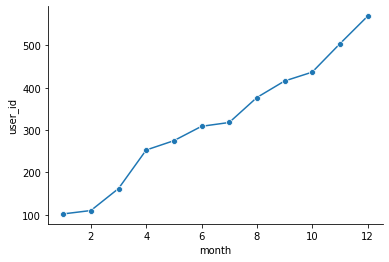

In [64]:
sns.lineplot(data=mau, marker='o')
sns.despine()

В течение всего года число уникальных пользователей увеличивалось.
MAU за апрель примерно в 2.5 раза больше, чем за январь